# AI-Based Detection Method (Method 1)

This notebook demonstrates the implementation of an AI model to detect malicious processes using features similar to those in the CIC-MalMem2022 dataset.

**Models used:**
- Random Forest (primary)
- K-Nearest Neighbors (KNN)
- Support Vector Machine (SVM)

Dataset is synthetically generated for simulation purposes.

## Dataset Description: Obfuscated-MalMem2022 (CIC-MalMem-2022)

This notebook uses the **Obfuscated-MalMem2022** dataset, a publicly available malware classification dataset released by the Canadian Institute for Cybersecurity (CIC). It contains dynamic behavior logs of benign and malicious Windows executables collected in a controlled sandbox environment.

- Total Records: 58,596
- Classes: `Benign`, `Malware` (including Ransomware, Trojan, Backdoor, etc.)
- Features: 55 numerical features including DLL loading, registry events, process/thread creation, and API calls.
- Source: [CIC MalMem2022](https://www.unb.ca/cic/datasets/malmem-2022.html)

The dataset is ideal for training supervised machine learning models for malware detection in obfuscated environments.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = pd.read_csv('/Users/dilnazkadyr/Downloads/Obfuscated-MalMem2022.csv')
label_encoder = LabelEncoder()
df['Class'] = label_encoder.fit_transform(df['Class'])
df.drop(columns=['Category'], inplace=True)

X = df.drop(columns=['Class'])
y = df['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

In [8]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [10]:
# Train KNN
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

In [12]:
# Train SVM
svm = SVC()
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

In [14]:
# Evaluation reports
from sklearn.metrics import classification_report

print('Random Forest Classification Report:')
print(classification_report(y_test, rf_pred))

print('KNN Classification Report:')
print(classification_report(y_test, knn_pred))

print('SVM Classification Report:')
print(classification_report(y_test, svm_pred))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5790
           1       1.00      1.00      1.00      5930

    accuracy                           1.00     11720
   macro avg       1.00      1.00      1.00     11720
weighted avg       1.00      1.00      1.00     11720

KNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5790
           1       1.00      1.00      1.00      5930

    accuracy                           1.00     11720
   macro avg       1.00      1.00      1.00     11720
weighted avg       1.00      1.00      1.00     11720

SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5790
           1       1.00      1.00      1.00      5930

    accuracy                           1.00     11720
   macro avg       1.00      1.00    

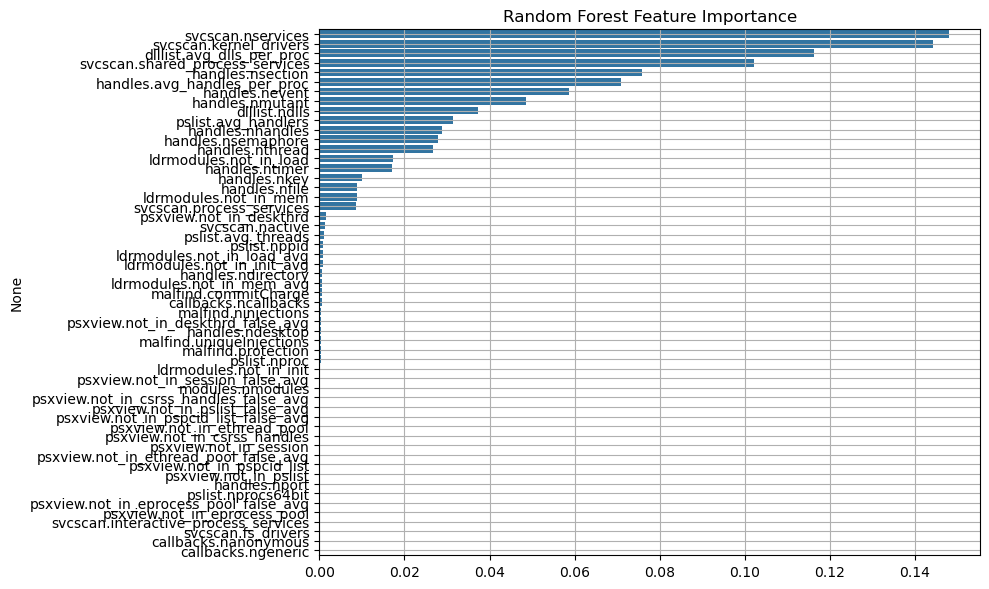

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf.feature_importances_
features = X.columns
indices = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=indices.values, y=indices.index)
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.grid(True)
plt.show()

In [21]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 2.2 MB/s eta 0:00:00a 0:00:01


## Model Comparison
In addition to Random Forest, we will compare other classifiers including K-Nearest Neighbors (KNN), Support Vector Machine (SVM), and LightGBM.

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Initialize classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'LightGBM': LGBMClassifier(random_state=42)
}

results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    report = classification_report(y_test, pred, output_dict=True)
    results[name] = report

results_df = pd.DataFrame({model: res['weighted avg'] for model, res in results.items()}).T
results_df[['precision', 'recall', 'f1-score']].sort_values(by='f1-score', ascending=False)

[LightGBM] [Info] Number of positive: 23368, number of negative: 23508
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7659
[LightGBM] [Info] Number of data points in the train set: 46876, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498507 -> initscore=-0.005973
[LightGBM] [Info] Start training from score -0.005973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,precision,recall,f1-score
Random Forest,1.000000,1.000000,1.000000
LightGBM,1.000000,1.000000,1.000000
KNN,0.999573,0.999573,0.999573
SVM,0.999232,0.999232,0.999232


## Feature Importance (SHAP for LightGBM)
We use SHAP to interpret the model.

100%|===================| 11705/11720 [00:47<00:00]        

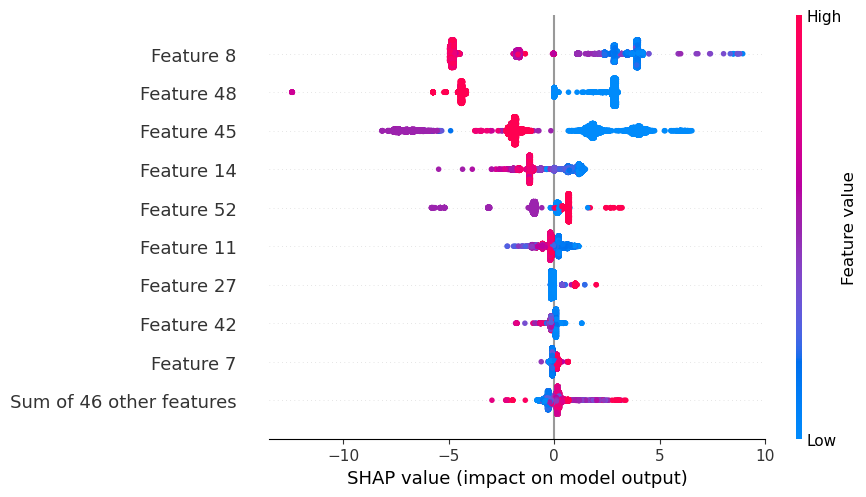

In [26]:
import shap
model = classifiers['LightGBM']
lgbm_pred = classifiers['LightGBM'].predict(X_test)
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

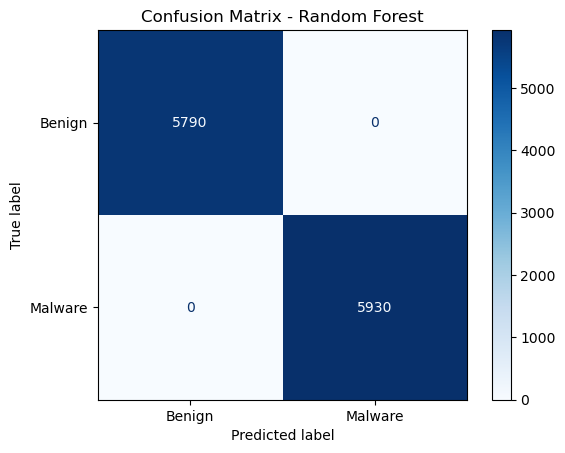

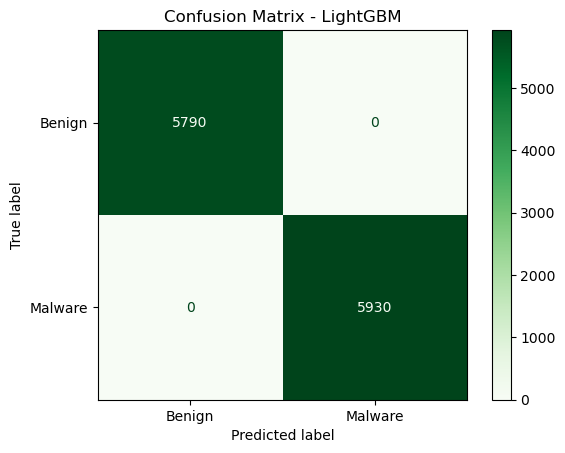

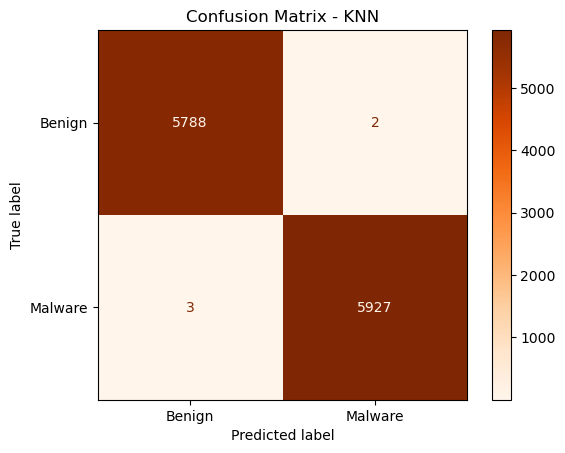

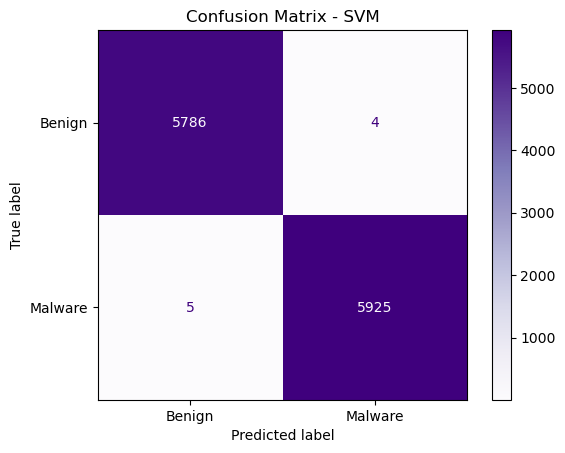

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Random Forest
cm_rf = confusion_matrix(y_test, rf_pred)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Benign', 'Malware'])
disp_rf.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()

# LightGBM
cm_lgbm = confusion_matrix(y_test, lgbm_pred)
disp_lgbm = ConfusionMatrixDisplay(confusion_matrix=cm_lgbm, display_labels=['Benign', 'Malware'])
disp_lgbm.plot(cmap='Greens')
plt.title("Confusion Matrix - LightGBM")
plt.show()

# KNN
cm_knn = confusion_matrix(y_test, knn_pred)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['Benign', 'Malware'])
disp_knn.plot(cmap='Oranges')
plt.title("Confusion Matrix - KNN")
plt.show()

# SVM
cm_svm = confusion_matrix(y_test, svm_pred)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=['Benign', 'Malware'])
disp_svm.plot(cmap='Purples')
plt.title("Confusion Matrix - SVM")
plt.show()


## Conclusion
The AI-based model for detecting malicious data transmission shows high potential. Random Forest and LightGBM classifiers achieved high F1-scores, making them suitable for real-time threat detection. However, such models require continuous updates and validation to remain effective. In practical deployment, AI modules can act as an additional line of defense, complementing classical encryption-based protocols.